## Modeling Selective Hearing in Rodents: A Replication
Owen McGrattan
<br>
Psych c127
<br>
ID: 3031834248


### Introduction

I wanted to take a look at some of the data from Mike DeWeese's experiments testing the ability of selective hearing in rats and measuring single unit neuronal responses in medial prefrontal cortex and primary auditory cortex. In the experiment, a rat would be exposed to multiple sounds at once but would only be able to respond to one of them.  It's similar to the way that we are able to focus on a voice in a crowded party or discern multiple voices at once.  Putting to test the idea that the brain is capable of discerning and comprehending different auditory stimuli is an important question to answer in cementing in its complex capability to filter various stimuli.  I wanted to build a classifier that would be able to take neuronal spikes as a function of the audio stimulus given and predict whether or not the rodent would choose the correct option.  It has already been found in the paper that prestimulus activity in the medial prefrontal cortex encoded the stimuli that the rat chose but I wanted to see whether or not I could replicate some of those results in here, infer the results of the paper from the data provided. 

### Method and Dataset Description

Our data has been provided by Mike DeWeese and Chris Rodgers, the authors of the paper.  Each folder in the data file represents a different rat that was used in testing and information on spike times, stimulus and behavioural response, and other trial event information such as stimulus onset.  Each rat was tasked with choosing a hole to poke its nose through based on pretrained audio stimuli.  If they had properly discerned the correct audio stimuli they would be rewared with a water droplet, if they hadn't they'd be placed on a temporary (2-6 s) timeout.  The rats were trained over several months or until they were more able than not to choose the correct audio stimuli.  Neuronal activity was recorded via implanting tetrodes in the brain, focusing on A1 and the mPFC. This allowed for proper recording of single-unit action potentials.  There are two rats of the six who only had data recorded from auditory cortex and we will not be including them in our analysis.

### Data Analysis

#### Cleaning and Prep

In [1]:
import numpy as np
import pandas as pd
from scipy import io as si
from matplotlib import pyplot as plt

Let's start reading in some of our data. Since all of our data is broken up into different trials, we should first try to open up just one rat's information before we go about aggregating or anything like that.

In [2]:
spike_times = pd.read_pickle('./data/CR20B/CR20B_120531_001_behaving/klusters0/CR20B_120531_001_behaving.kkp')

In [5]:
spike_times.head()

,group,time,unit
0,1,0.380000,105
1,1,0.381733,105
2,1,0.664733,105
3,1,0.684000,105
4,1,0.773700,105


Before we go any further importing the other data files associated with the same day of testing, we ought to understand the spike times columns and what the values mean.  
<br> 
<b> time </b> - time of the spike in seconds from the beginning of recording session
<br>
<b> unit </b> - indicator of which single unit produced the spike.  first digit indicates tetrode num it was recorded from
<br>
<b> group </b> - tetrode num

In [52]:
# now to import and join our trial info and timings
trial_info = pd.read_table('./data/CR20B/CR20B_120531_001_behaving/trials_info', sep = ',', index_col = 0)
trial_timing = pd.read_table('./data/CR20B/CR20B_120531_001_behaving/trial_timings', sep = ',', index_col = 0)
trial_info = trial_timing.join(trial_info)

In [53]:
trial_info.head()

,choice_made,cpoke_start,cpoke_stop,stim_onset,is_munged,correct_side,stim_number,nonrandom,outcome,go_or_nogo,block,stim_name
3,238.074050,237.264617,237.588191,237.523909,False,left,3,1,hit,go,1,le_lc_go
4,250.086150,249.086196,249.487838,249.413257,False,left,3,1,hit,go,1,le_lc_go
5,256.169274,255.248223,255.625775,255.586242,False,left,3,1,hit,go,1,le_lc_go
6,264.177063,263.206840,263.586723,263.531909,False,left,3,1,hit,go,1,le_lc_go
7,271.603650,270.693224,270.998028,270.956502,False,left,3,1,hit,go,1,le_lc_go


Let's breakdown what is going on in this dataframe.

Each row in the data frame represents a different session

<b> block </b> - Number (1-4) representing the type of repeated trial (will explain in more detail a little later)
<br> 
<b> stimulus_name </b> - Gives localization sound (left, right), pitch discrimination (low, high warble), and block (localization, pitch discrimination)
<br>
<b> nonrandom </b> - whether or not trial was nonrandom
<br>
<b> is_munged </b> - whether or not trial was unsuitable for analysis
<br>
<b> correct_side </b> - 'left' for blocks 1 and 2, 'right' for 3 and 4. 
<br> 
<b> outcome </b> - 'hit' for success, 'wrong_port' or 'future_trial' for incorrect
<br> 
<b> cpoke_start </b> - time when the rat initiated a trial by poking center port
<br> 
<b> stim_onset </b> - time at which auditory stimulus began
<br> 
<b> choice_made </b> - time at which rat entered the choice port.
<br> 
<b> cpoke_stop </b> - time at which rat withdrew from center port 



In [54]:
# lets summarise how much time is going on in each trial
# from stimulation to choice made
trial_info['stim_choice'] = trial_info['choice_made'] - trial_info['stim_onset']

It does seem that our time variables between our trial_info and spike_times datasets can align and give us the information we need on when we see neuronal spikes in relation to our trial_info data.  It would make the most sense to add information into our trial_info dataframe since for the purposes of this analysis we aren't so worried about pre or post trial activity.  We should be adding different columns to account for the spiking activity in the different tetrode locations.

In [75]:
# loop through each trial in our trial_info set
# isolate the spike data that pertains the interval of the trial
a1_spike = [None] * len(trial_info)
mpfc_spike = [None] * len(trial_info)
for i in range(len(trial_info)):
    start = trial_info.iloc[i, 1]
    stop = trial_info.iloc[i, 0]
    stim = trial_info.iloc[i, 3]
    # subset spike data by start and stop times
    spike = spike_times[(spike_times['time'] >= start) & (spike_times['time'] <= stop)]
    a1 = spike[spike['group'] < 5]
    mpfc = spike[spike['group'] > 4]
    a1_spike[i] = len(a1.index) / (stop - stim)
    mpfc_spike[i] = len(mpfc.index) / (stop - stim)

trial_info['a1_spike'] = a1_spike
trial_info['mpfc_spike'] = mpfc_spike

In calculating the spike rate for the different locations, I wasn't completely sure about what was best fitting but I figured calling for the mean was most appropriate in that it would be properly weighted for the high spikes in such a short period of time.

As a sanity check, let's go through and see how an example trial period would look based on the trial timing period, the stimulus onset, and the spiking data

In [148]:
trial_info.head()

,choice_made,cpoke_start,cpoke_stop,stim_onset,is_munged,correct_side,stim_number,nonrandom,outcome,go_or_nogo,block,stim_name,stim_choice,a1_spike,mpfc_spike
3,238.074050,237.264617,237.588191,237.523909,False,left,3,1,hit,go,1,le_lc_go,0.550141,216.308068,303.558381
4,250.086150,249.086196,249.487838,249.413257,False,left,3,1,hit,go,1,le_lc_go,0.672893,203.598422,315.057412
5,256.169274,255.248223,255.625775,255.586242,False,left,3,1,hit,go,1,le_lc_go,0.583032,284.718337,415.071311
6,264.177063,263.206840,263.586723,263.531909,False,left,3,1,hit,go,1,le_lc_go,0.645154,210.802447,347.204031
7,271.603650,270.693224,270.998028,270.956502,False,left,3,1,hit,go,1,le_lc_go,0.647148,236.421935,261.145798


Text(0.5, 1.0, 'Neuronal Spikes During a Trial')

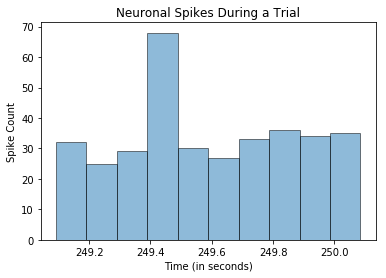

In [165]:
# go through an example and plot spiking data for a trial
start = trial_info.iloc[1, 1]
stop = trial_info.iloc[1, 0]
stim = trial_info.iloc[1, 3]
spike = spike_times[(spike_times['time'] >= start) & (spike_times['time'] <= stop)]
plt.hist(spike['time'], alpha = 0.5, edgecolor = 'black')
plt.ylabel('Spike Count')
plt.xlabel('Time (in seconds)')
plt.title('Neuronal Spikes During a Trial')

Sweet.  We are able to incorporate both our trial data and our spike data together but we need to apply our method to each of the other sessions as well. Best to rework everything that was done above into a function to make things a little quicker.

In [90]:
# quick and easy way to grab the directory names we need
import os
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]
rats = get_immediate_subdirectories('data')
rats.remove('CR12B')
rats.remove('CR17B')
rats.remove('miscellaneous')
rats

['CR24A', 'YT6A', 'CR20B', 'CR21A']

In [181]:
import itertools
# grab a list of directories to import the data through
trial_list = []
timing_list = []
spike_list = []
for i in range(len(rats)):
    sub_list = get_immediate_subdirectories('data/' + rats[i])
    trial_list.append(['./data/' + rats[i] + '/' + sub_list[j] + '/trials_info' for j in range(len(sub_list))])
    timing_list.append(['./data/' + rats[i] + '/' + sub_list[j] + '/trial_timings' for j in range(len(sub_list))])
    spike_list.append(['./data/' + rats[i] + '/' + sub_list[j] + '/klusters0/' + sub_list[j] + '.kkp' for j in range(len(sub_list))])
# flatten each list 
trial_list = list(itertools.chain.from_iterable(trial_list))
timing_list = list(itertools.chain.from_iterable(timing_list))
spike_list = list(itertools.chain.from_iterable(spike_list))
def work_thru_data(lst, lst2, lst3):
    t = 0
    for i in range(len(lst)):
        t += 1
        trial_info = pd.read_table(lst[i], sep = ',', index_col = 0)
        trial_timing = pd.read_table(lst2[i], sep = ',', index_col = 0)
        trial_info = trial_timing.join(trial_info)
        trial_info['stim_choice'] = trial_info['choice_made'] - trial_info['stim_onset']
        
        spike_times = pd.read_pickle(lst3[i])
        # loop through each trial in our trial_info set
        # isolate the spike data that pertains the interval of the trial
        a1_spike = [None] * len(trial_info)
        mpfc_spike = [None] * len(trial_info)
        for i in range(len(trial_info)):
            start = trial_info.iloc[i, 1]
            stop = trial_info.iloc[i, 0]
            stim = trial_info.iloc[i, 3]
            # subset spike data by start and stop times
            spike = spike_times[(spike_times['time'] >= start) & (spike_times['time'] <= stop)]
            a1 = spike[spike['group'] < 5]
            mpfc = spike[spike['group'] > 4]
            a1_spike[i] = len(a1.index) / (stop - stim)
            mpfc_spike[i] = len(mpfc.index) / (stop - stim)

        trial_info['a1_spike'] = a1_spike
        trial_info['mpfc_spike'] = mpfc_spike
        
        if t == 1:
            df = trial_info
            df = df.reset_index(drop = True)
        else:
            trial_info = trial_info.reset_index(drop = True)
            df.append(trial_info)
    return df

dat = work_thru_data(trial_list, timing_list, spike_list)
    
        

In [182]:
len(dat)

1433

So we have 1433 examples to work with in this case.  Before we go into prediction, let's see how well trained these rats were.  What does the class balance look like.

In [184]:
# drop rows that weren't used for analysis in the paper
dat = dat[dat['nonrandom'] != 1]
dat = dat[dat['is_munged'] != True]

# pct of wrong choices
print((len(dat[dat['outcome'] != 'hit']) / len(dat)) * 100)
print(len(dat))

19.58684009181331
1307


Alright, these rats have been well trained, making a mistake about roughly 20% of the time.  Nevertheless it's important for us to get a better understanding as to why these rats chose incorrectly in the first place. Some more cleaning will be needed and a lot of class imbalance will need to be accounted for.

After getting rid of the bad trials in the set we have made our way down to 1307 trials in the set. 

In [185]:
# reset timing variables (may be adding some bias)
dat['choice_made'] = dat['choice_made'] - dat['cpoke_start']
dat['cpoke_stop'] = dat['cpoke_stop'] - dat['cpoke_start']
dat['stim_onset'] = dat['stim_onset'] - dat['cpoke_start']

In [186]:
# now for the columns to drop
dat.drop(columns = ['cpoke_start', 'is_munged', 'nonrandom', 'stim_name', 'correct_side'], inplace = True)

,choice_made,cpoke_stop,stim_onset,stim_number,outcome,go_or_nogo,block,stim_choice,a1_spike,mpfc_spike
1,0.836509,0.360118,0.297995,3,hit,go,1,0.538514,189.410016,50.137945
2,0.929028,0.398154,0.330052,4,error,nogo,1,0.598976,193.663751,38.398847
3,1.284496,0.435858,0.334039,3,error,go,1,0.950457,139.932748,14.729763
4,0.778703,0.342177,0.285202,3,hit,go,1,0.493501,198.581101,12.158027
5,0.857935,0.382210,0.343839,3,hit,go,1,0.514096,171.174367,33.067775


In [192]:
# transform some of our categorical variables
dat['go'] = [1 if i == 'go' else 0 for i in dat['go_or_nogo']]
dat['correct_choice'] = [1 if i == 'hit' else 0 for i in dat['outcome']]
dat.drop(columns = ['outcome', 'go_or_nogo'], inplace = True)

Before we go forward with fitting our model, let's take a look at which variables have some relation with one another.  Here's a heatmap for all of our variables.

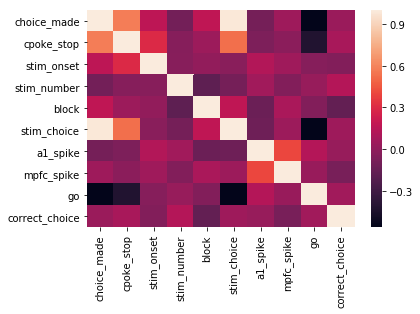

In [194]:
import seaborn as sns
sns.heatmap(dat.corr())
plt.show()

Of course our choice_made and stim_choice are going to be highly correlated to one another but it appears that many of the other variables are largely uncorrelated with one another.  Before going into fitting a model it'd be useful to drop one of either our choice_made or stim_choice columns since including both adds in unnecessary noise and could cause error later on.

#### Modeling

Now that we have done our work gathering and cleaning up the data, it is time to do a little bit of prediction to see if anything about the neuronal firing of the rats can tell us how they responded to the audio stimuli.

First up, some logistic regression.

In [222]:
from sklearn.model_selection import train_test_split
# set up data for splitting
y = dat['correct_choice']
X = dat.drop(columns = ['correct_choice'])
# split data into test and train splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117d9c080>)

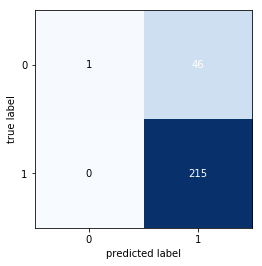

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
lr = LogisticRegression()
lr.fit(X_train, y_train)

# get our predictions
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

In [203]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.04      0.07        57
          1       0.79      1.00      0.88       205

avg / total       0.76      0.79      0.70       262



Here we see some of our class imbalance rise up. We didn't make any error in predicting any rat mistakes that actually weren't,  but we incorrectly predicted far fewer mistakes than there actually were.

One solution for us is to retry our logistic regression but try and account for our imbalance.

             precision    recall  f1-score   support

          0       0.22      0.51      0.31        47
          1       0.85      0.60      0.71       215

avg / total       0.74      0.59      0.63       262



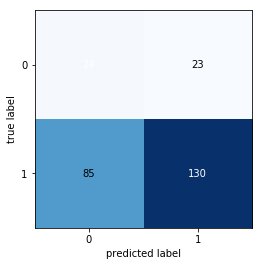

In [225]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
print(classification_report(y_test, y_pred))

We've made things a little better by adjusting for our class imbalance but we've created a new issue where we predict far more errors that didn't occur in the first place.  We can be dealing with a threshold that is far too high or far too low.  We may be asking for too high or too low of a probability to classify in this situation.

Best parameters : {'class_weight': {0: 0.618421052631579, 1: 0.381578947368421}}


/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/owenmcgrattan/min

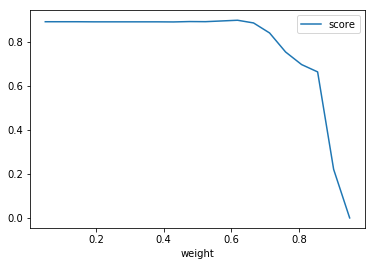

In [227]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

It does seem that we needed a tiny bit of tuning to give ourself the weights that gave us the best balance between our false negatives and false positives.  Let's see how our updated model does now.

             precision    recall  f1-score   support

          0       0.83      0.11      0.19        47
          1       0.84      1.00      0.91       215

avg / total       0.84      0.84      0.78       262



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166f9828>)

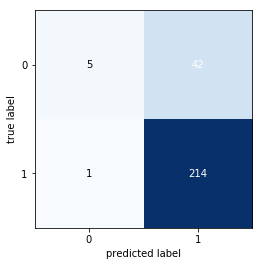

In [228]:
lr = LogisticRegression(**grid_result.best_params_)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

Well it does appear that our best case scenario with our data here was to follow something similar to our original model.  

Maybe a different kind of classifier might work better.
Let's try a Random Forest.

             precision    recall  f1-score   support

          0       0.98      0.85      0.91        47
          1       0.97      1.00      0.98       215

avg / total       0.97      0.97      0.97       262



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11812ae10>)

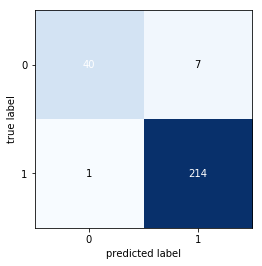

In [230]:
# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

And we have something much better.  A total of 8 total incorrect classifications, still weighted towards our false positives but nevertheless a remarkable jump.

Now that we've built our Random Forest classifier, it's time we take a look at which features it found most important in making its predictions.

In [247]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
stim_choice,0.305414
go,0.217278
choice_made,0.149246
stim_number,0.069834
cpoke_stop,0.068868
mpfc_spike,0.067862
a1_spike,0.044382
stim_onset,0.041388
block,0.035728


While none of these features have drastic standouts over one another, the biggest factor in classification for this problem was the time from the stimulus onset to the rat making its choice.  Unfortunately, our measures of a1 and mpfc spikes were not very important factors in classification for this problem.

### Discussion

There were likely many issues that I had brought about through my analysis.  Maybe things would be different if I had incorporated the data in a timeseries format, but the low number of errors may suggest that it would not make much of a difference at all.  There may have been issues in  the recording of the neural spike data or that these rats have already had extensive training, already altering their brain chemistry by quite a bit.  I could also be misinterpreting the spike data itself, making the incorrect assumption that more spikes equals more meaningful thinking  or greater processing.  I'm sure there were quite a few errors made here but in working through this information and trying to predict rat behavior like a data scientist, I was able to find that there was no way for the simplicity of our neuronal data to tell us about the complex nature of what truly goes on behind the decision making process of rats filtering through multiple audial stimuli.

### References

Rodgers CC, DeWeese MR. (2014); Spiking responses of neurons in rodent prefrontal cortex and auditory cortex during a novel stimulus selection task. CRCNS.org.
http://dx.doi.org/10.6080/K0W66HPJ